# <html>

   

<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: auto; margin: 10px;">

  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/University_of_Tehran_logo.svg/225px-University_of_Tehran_logo.svg.png" width=100px width=auto style="padding:10px; vertical-align: center;">



</div>

   

<div   style:"text-align: center; background-image: linear-gradient(to left, rgb(255, 255, 255), rgb( 219, 204, 245  ));width: 400px; height: 30px; ">

<h1 style="font-family: Georgia; color: black; text-align: center; ">Course: NNDL </h1>



</div>

<div   style:"border: 3px solid green;text-align: center; ">

<h1 style="font-family: Georgia; color: black; text-align: center; ">Project3 - Question1 </h1>



</div>



   <div>    

<h1 style="font-family: Georgia; color: black; text-align: center; font-size:15px;">Mohammad Amanlou- sid:810100084 </h1>
<h1 style="font-family: Georgia; color: black; text-align: center; font-size:15px;">Mohammad Mahdi Kabi- sid:810102561 </h1>





</div>

   



</html>

In [1]:
import kagglehub
import shutil
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [ ]:
def load_and_split_data(img_path):
    if not os.path.exists('TRAIN'):
        os.makedirs('TRAIN')
    if not os.path.exists('VAL'):
        os.makedirs('VAL')
    if not os.path.exists('TEST'):
        os.makedirs('TEST')
    
    for class_folder in os.listdir(img_path):
        class_path = os.path.join(img_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        img_num = len(os.listdir(class_path))
        
        for n, file_name in enumerate(os.listdir(class_path)):
            if file_name.endswith(".tif") and not file_name.endswith("_mask.tif"):
                img = os.path.join(class_path, file_name)
                mask = img.replace(".tif", "_mask.tif")
                
                if not os.path.exists(mask):
                    print(f"Warning: Mask file not found for image {img}")
                    continue
                
                if (n < int(0.2 * img_num) and n%2 == 0):
                    dest_path = os.path.join('TEST', class_folder.upper())
                elif (n < int(0.2 * img_num) and n%2 == 1):
                    dest_path = os.path.join('VAL', class_folder.upper())
                else:
                    dest_path = os.path.join('TRAIN', class_folder.upper())
                
                if not os.path.exists(dest_path):
                    os.makedirs(dest_path)
                
                shutil.copy(img, os.path.join(dest_path, file_name))
                shutil.copy(mask, os.path.join(dest_path, os.path.basename(mask)))

load_and_split_data(os.path.join(path, 'kaggle_3m'))


In [3]:
def load_data_from_directory(directory, img_size=(256, 256)):
    X = []
    y = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        for file_name in os.listdir(class_path):
            if file_name.endswith(".tif") and not file_name.endswith("_mask.tif"):
                img_path = os.path.join(class_path, file_name)
                mask_path = img_path.replace(".tif", "_mask.tif")

                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if img is None or mask is None:
                    continue

                img = cv2.resize(img, img_size)
                mask = cv2.resize(mask, img_size)

                X.append(img)
                y.append(mask)

    X = np.array(X) / 255.0
    y = np.array(y) / 255.0
    y = np.expand_dims(y, axis=-1)

    return X, y

In [4]:
def show_samples(X, y, num_samples=6):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(np.clip(X[i], 0, 1))
        plt.title("Raw Image")
        plt.axis('off')

        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Mask Only")
        plt.axis('off')

        combined = X[i].copy()
        combined[y[i].squeeze() > 0] = [1, 0, 0]
        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(np.clip(combined, 0, 1))
        plt.title("Image with Mask")
        plt.axis('off')
    plt.show()

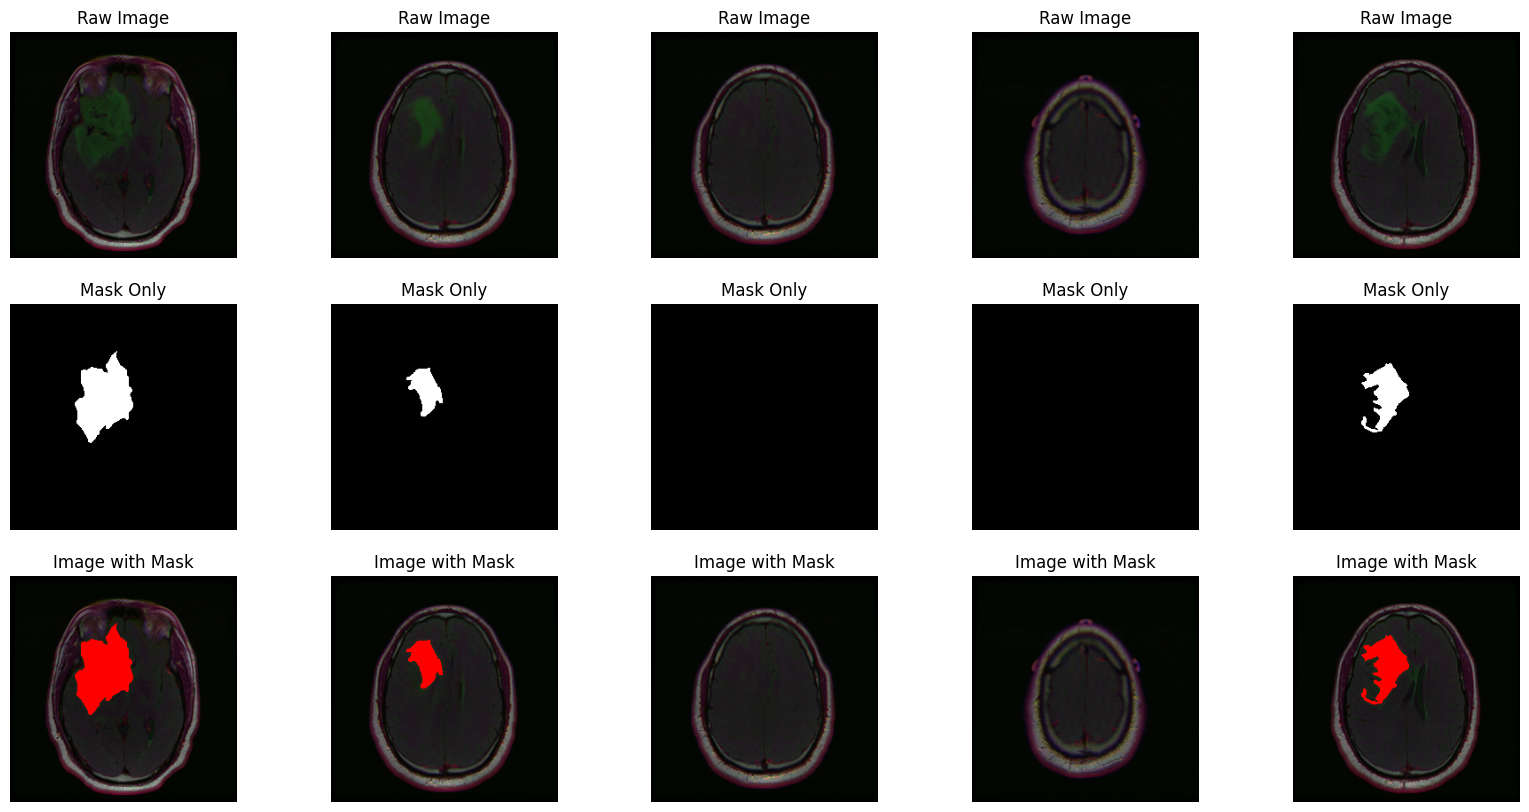

In [5]:
X_train, y_train = load_data_from_directory('TRAIN')
X_val, y_val = load_data_from_directory('VAL')
X_test, y_test = load_data_from_directory('TEST')

show_samples(X_train, y_train, num_samples=5)

In [ ]:
print("\n" + "="*30 + '\n')
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")
print("="*30 + "\n\n")

==============================

Number of training samples: 3145

Number of validation samples: 392

Number of test samples: 392

==============================

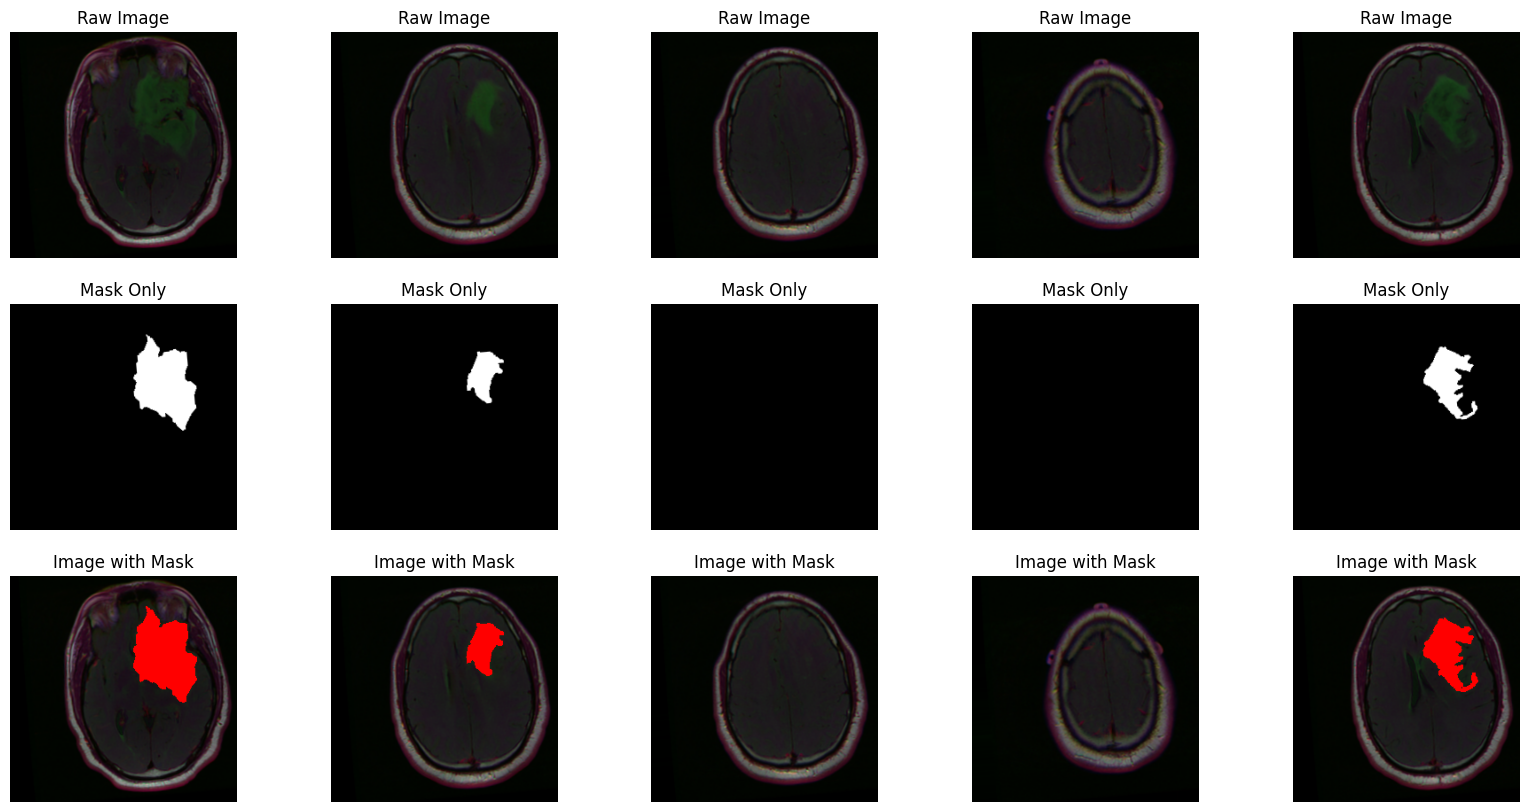

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest',
                     brightness_range = (0.8,1.1))

data_gen = ImageDataGenerator(**data_gen_args)
augmented_X, augmented_y = [], []

for i in range(6):
    img = X_train[i] * 255
    mask = y_train[i] * 255
    img = np.expand_dims(img, 0)
    mask = np.expand_dims(mask, 0)
    seed = 42
    for img_aug, mask_aug in zip(data_gen.flow(img, seed=seed), data_gen.flow(mask, seed=seed)):
        augmented_X.append(img_aug[0])
        augmented_y.append(mask_aug[0])
        break

augmented_X = np.array(augmented_X) / 255
augmented_y = np.array(augmented_y) / 255

show_samples(augmented_X, augmented_y, num_samples=5)

In [8]:
from tensorflow.keras import backend as K
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def combined_dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [9]:
def build_unet_vgg16(img_size=(256, 256)):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in vgg16.layers[:-4]:  # Unfreeze last 4 layers for fine-tuning
        layer.trainable = True
    
    inputs = vgg16.input
    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output
    s3 = vgg16.get_layer('block3_conv3').output
    s4 = vgg16.get_layer('block4_conv3').output
    
    b5 = vgg16.get_layer('block5_conv3').output
    
    u6 = UpSampling2D((2, 2))(b5)
    u6 = concatenate([u6, s4])
    c6 = Conv2D(512, (3, 3), padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = LeakyReLU()(c6)
    c6 = Dropout(0.5)(c6)
    c6 = Conv2D(512, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = LeakyReLU()(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, s3])
    c7 = Conv2D(256, (3, 3), padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = LeakyReLU()(c7)
    c7 = Dropout(0.5)(c7)
    c7 = Conv2D(256, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = LeakyReLU()(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, s2])
    c8 = Conv2D(128, (3, 3), padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = LeakyReLU()(c8)
    c8 = Dropout(0.5)(c8)
    c8 = Conv2D(128, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = LeakyReLU()(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, s1])
    c9 = Conv2D(64, (3, 3), padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = LeakyReLU()(c9)
    c9 = Dropout(0.5)(c9)
    c9 = Conv2D(64, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = LeakyReLU()(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_dice_bce_loss, metrics=['accuracy', dice_coefficient, iou_score])
    return model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
model = build_unet_vgg16()
checkpoint = ModelCheckpoint('unet_vgg16_brain_tumor.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
X_train_augmented = np.concatenate((X_train, augmented_X), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_y), axis=0)

history = model.fit(X_train_augmented, y_train_augmented, validation_data=(X_val, y_val), epochs=30, batch_size=16, callbacks=[checkpoint, early_stopping], verbose=1)


Epoch 1/30


I0000 00:00:1733494866.276615      96 service.cc:145] XLA service 0x7ba148002340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733494866.276693      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733494910.329368      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 173s 679ms/step - accuracy: 0.7644 - dice_coefficient: 0.0407 - iou_score: 0.0209 - loss: 1.5189 - val_accuracy: 0.9632 - val_dice_coefficient: 0.0925 - val_iou_score: 0.0495 - val_loss: 1.2024
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 422ms/step - accuracy: 0.9896 - dice_coefficient: 0.0861 - iou_score: 0.0454 - loss: 1.1056 - val_accuracy: 0.9895 - val_dice_coefficient: 0.1105 - val_iou_score: 0.0599 - val_loss: 1.0661
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.9927 - dice_coefficient: 0.1327 - iou_score: 0.0722 - loss: 1.0009 - val_accuracy: 0.9957 - val_dice_coefficient: 0.1574 - val_iou_score: 0.0885 - val_loss: 0.9419
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.9942 - dice_coefficient: 0.1777 - iou_score: 0.1001 - loss: 0.9164 - val_accuracy: 0.9965 - val_dice_coefficient: 0.2131 - val_iou_score: 0.1248 - val_loss: 0.8497
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.9956 - di

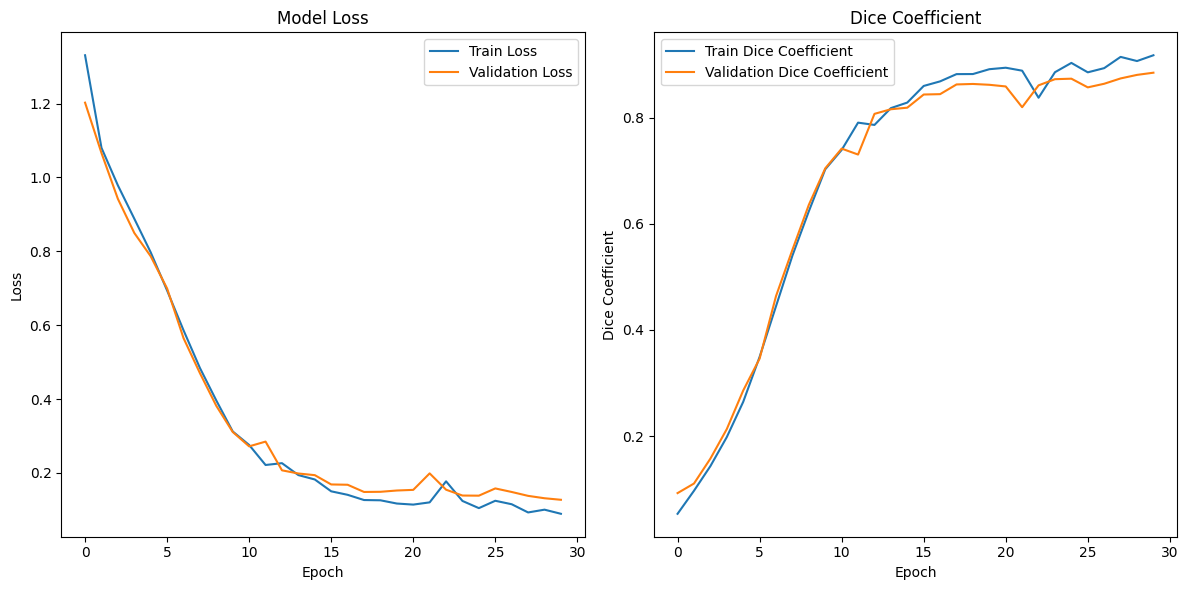

In [14]:
# Plotting training history
plt.figure(figsize=(12, 6))

# Plotting training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation Dice Coefficient values
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


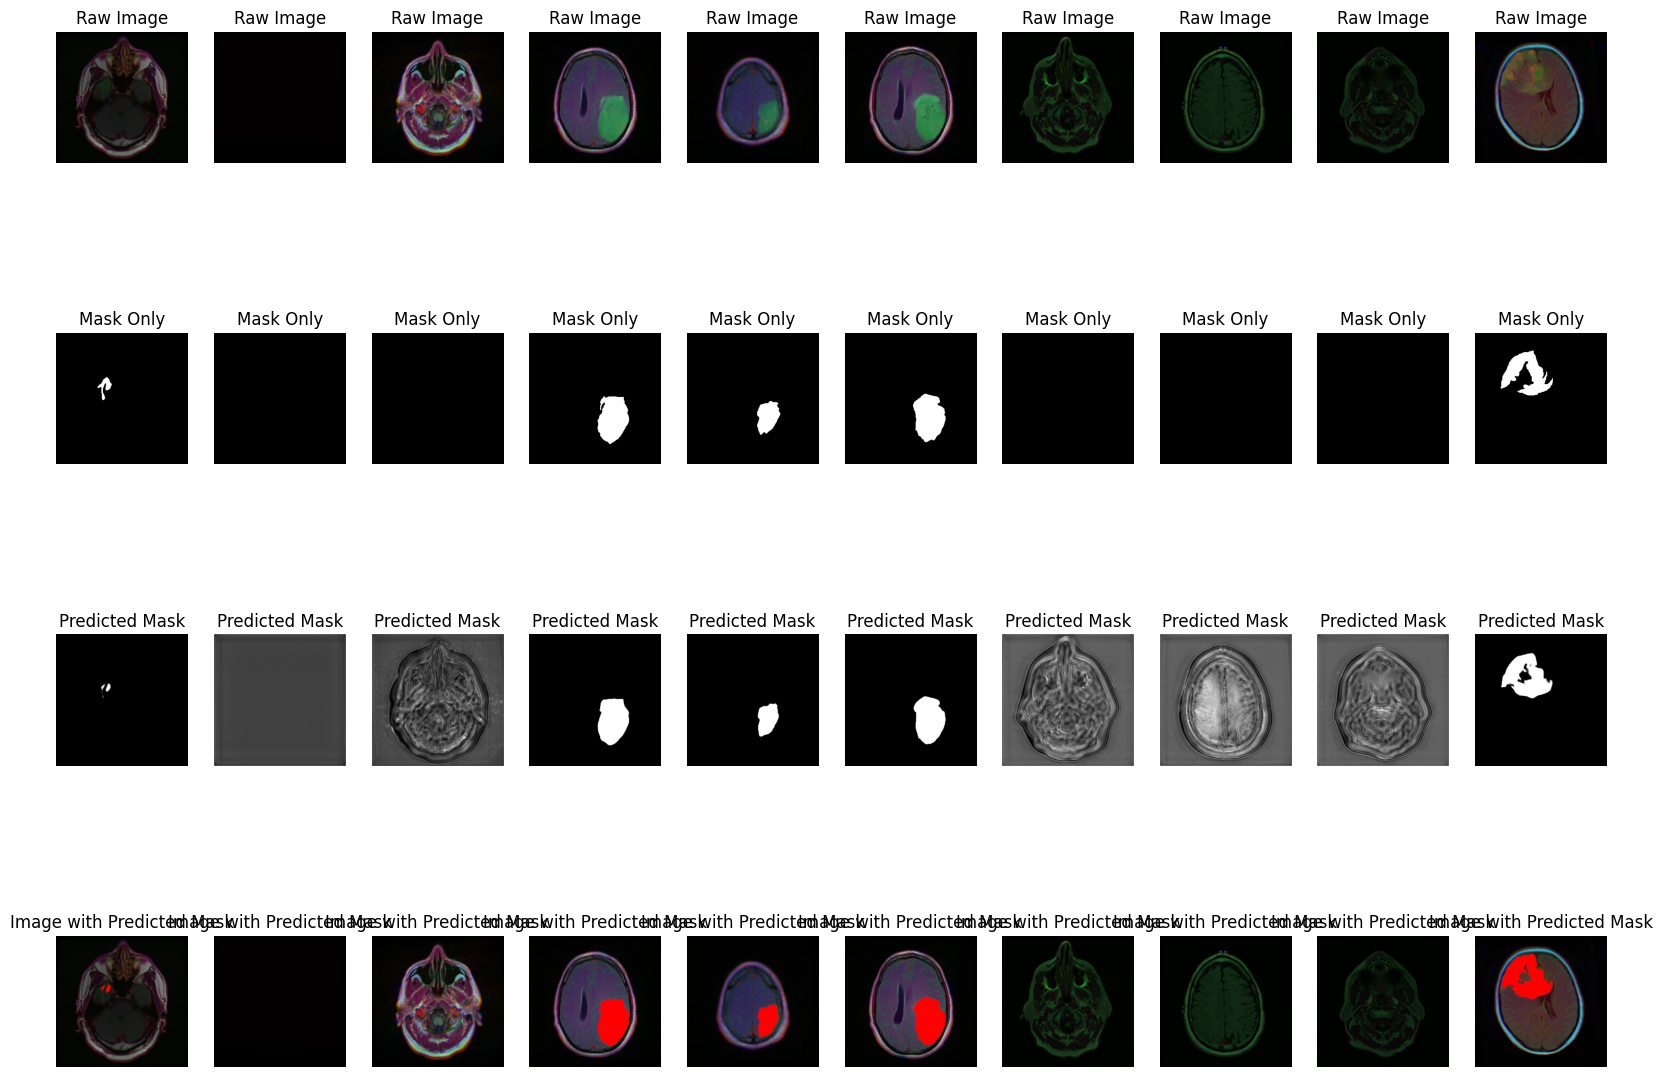

In [15]:
def show_test_predictions(model, X, y, num_samples=10):
    predictions = model.predict(X[:num_samples])
    plt.figure(figsize=(20, 15))
    for i in range(num_samples):
        plt.subplot(4, num_samples, i + 1)
        plt.imshow(np.clip(X[i], 0, 1))
        plt.title("Raw Image")
        plt.axis('off')

        plt.subplot(4, num_samples, num_samples + i + 1)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Mask Only")
        plt.axis('off')

        plt.subplot(4, num_samples, 2 * num_samples + i + 1)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        combined = X[i].copy() 
        combined[predictions[i].squeeze() > 0.5] = [1, 0, 0]
        plt.subplot(4, num_samples, 3 * num_samples + i + 1)
        plt.imshow(np.clip(combined, 0, 1))
        plt.title("Image with Predicted Mask")
        plt.axis('off')
    plt.show()

show_test_predictions(model, X_test, y_test, num_samples=10)